In [1]:
import numpy as np
import pandas as pd

In [2]:
train_fname = './data/train.tsv'
test_fname = './data/test.tsv'

In [3]:
df_train = pd.read_csv(train_fname, sep='\t')
df_test = pd.read_csv(test_fname, sep='\t')

In [4]:
df_train.head()

,sentiment,review
0,1,But it's really slow to catch on . For me a mo...
1,1,"To me, it's controversial how this movie has s..."
2,1,"The movie is a tricky and the story is good, b..."
3,0,I can not believe that this movie received all...
4,2,Usually the debate is wether godfather or Good...


In [5]:
df_train['sentiment'].value_counts()

sentiment
2    10932
0    10929
1    10884
Name: count, dtype: int64

Text(0.5, 0, 'Sentiment')

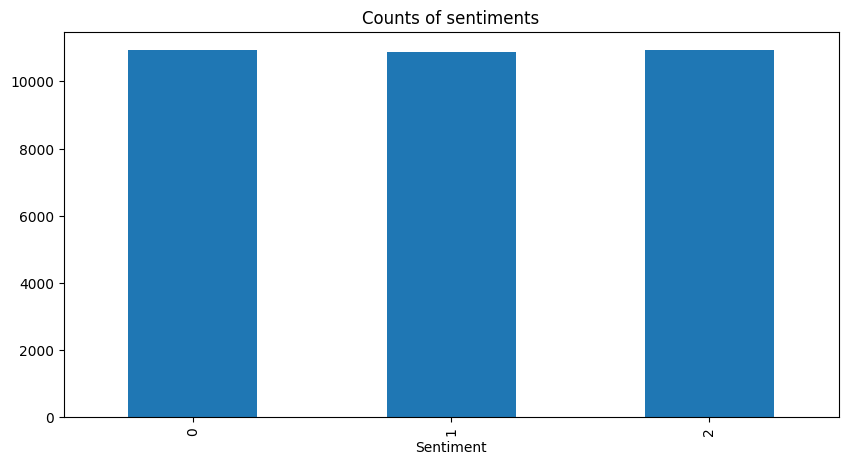

In [6]:
ax = df_train['sentiment'].value_counts().sort_index().plot(kind='bar', title='Counts of sentiments', figsize=(10, 5))
ax.set_xlabel('Sentiment')

In [7]:
import re
import nltk
import spacy

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [8]:
nltk.download('punkt')
nltk.download('wordnet')

if not spacy.util.is_package("en_core_web_sm"):
    spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
to_replace = {
    "don\'t": "do not",
    "dont": "do not",
    "doesn\'t": "does not",
    "doesnt": "does not",
    "didn\'t": "did not",
    "didnt": "did not",
    "shouldn\'t": "should not",
    "shouldnt": "should not",
    "mustn\'t": "must not",
    "mustnt": "must not",
    "haven\'t": "have not",
    "hvn\'t": "have not",
    "havent": "have not",
    "hadn\'t": "had not",
    "hadnt": "had not",
    "can\'t": "can not",
    "cant": "can not",
    "cannot": "can not",
    "cann\'t": "can not",
    "couldn\'t": "could not",
    "couldnt": "could not",
    "aren\'t": "are not",
    "arent": "are not",
    "isn\'t": "is not",
    "isnt": "is not",
    "wasn\'t": "was not",
    "wasnt": "was not",
    "weren\'t": "were not",
    "werent": "were not",
    "won\'t": "will not",
    "wont": "will not",
    "wouldn\'t": "would not",
    "wouldnt": "would not",
}

In [11]:
stopwords = []

with open('./data/stopwords.txt', 'r') as file:
    for line in file:
        stopwords.append(line.strip())

print(stopwords)

['i', 'me', 'my', 'mine', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'how', 'when', 'where', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'but', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'among', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'not', 'no', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will

In [12]:
def replace_contractions(sentence, to_replace):
    pattern = re.compile(r'\b(' + '|'.join(to_replace.keys()) + r')\b')
    
    return pattern.sub(lambda x: to_replace[x.group()], sentence)

def decontracted(phrase):
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = text.lower()
    text = replace_contractions(text, to_replace)
    text = decontracted(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    words = word_tokenize(text)

    filtered_words = [word for word in words if not word in stopwords  and len(word) > 2]
    lemmas = []
    for word in filtered_words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    sentence = ' '.join(lemmas)
    doc = nlp(sentence)
    lemmas = [token.lemma_ for token in doc]

    return ' '.join(lemmas)

In [14]:
example = "I don't like this movie, it doesn't make sense. he won't watch it again in 2024 @ !"
print(clean_text(example))

like make sense watch


In [15]:
from tqdm import tqdm
tqdm.pandas()

df_train['words'] = df_train['review'].progress_apply(clean_text)
df_test['words'] = df_test['review'].progress_apply(clean_text)

100%|██████████| 2681/2681 [00:50<00:00, 53.06it/s]


In [16]:
df_negative = df_train[df_train['sentiment'] == 0]
df_neutral = df_train[df_train['sentiment'] == 1]
df_positive = df_train[df_train['sentiment'] == 2]

def count_words(df):
    word_counts = {}
    for review in df['words']:
        words = review.split()
        for word in words:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
    return word_counts

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

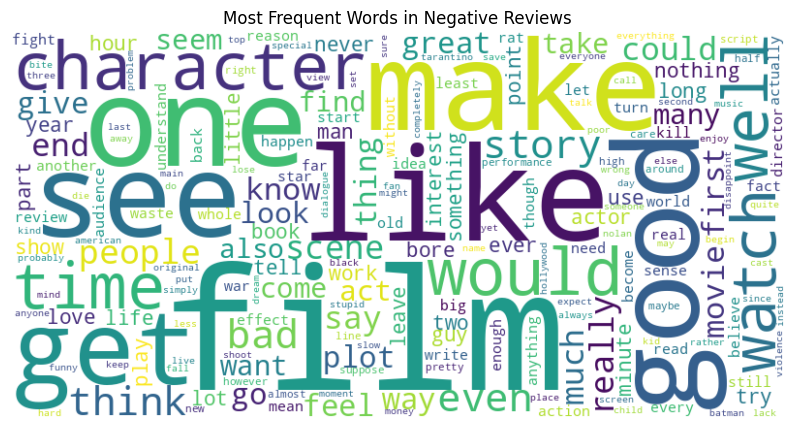

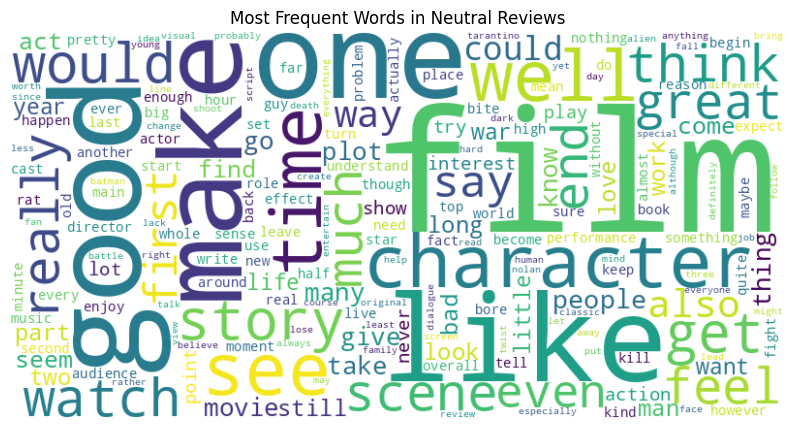

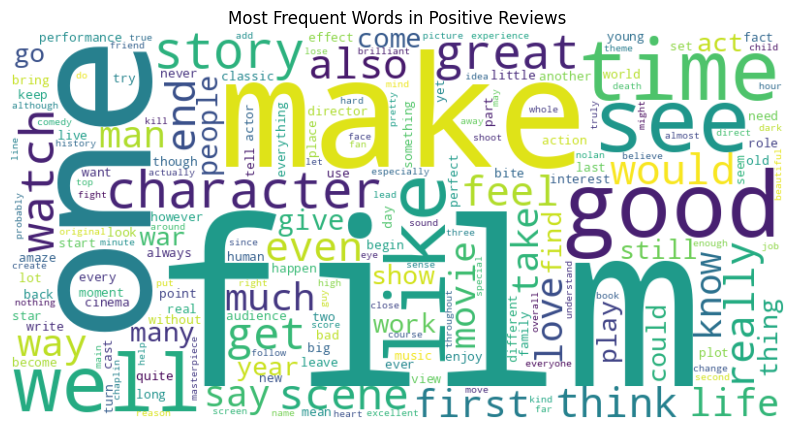

In [18]:
word_counts_negative = count_words(df_negative)
create_wordcloud(word_counts_negative, 'Most Frequent Words in Negative Reviews')

word_counts_neutral = count_words(df_neutral)
create_wordcloud(word_counts_neutral, 'Most Frequent Words in Neutral Reviews')

word_counts_positive = count_words(df_positive)
create_wordcloud(word_counts_positive, 'Most Frequent Words in Positive Reviews')

In [19]:
from collections import Counter

def get_corpus(df):
    corpus = []
    for i in tqdm(range(len(df))):
        corpus.append(df['words'].values[i].split())
    corpus = Counter(np.hstack(corpus))
    corpus2 = sorted(corpus, key=corpus.get, reverse=True)
    corpus2 = ['<UNK>'] + corpus2
    vocab = {word: idx for idx, word in enumerate(corpus2, 1)}
    return corpus, vocab

In [20]:
combined_df = pd.concat([df_train, df_test], ignore_index=True)
corpus, vocab = get_corpus(combined_df)

print(len(vocab))

100%|██████████| 35426/35426 [00:00<00:00, 47397.18it/s]


55629


In [21]:
import pickle

with open('/kaggle/working/tokenizer.pkl', 'wb') as file:
    pickle.dump(vocab, file)

In [22]:
def phrase_to_ints(text):
    words = [word for word in text.split()]
    ints = [vocab.get(word, vocab['<UNK>']) for word in words]
    return ints

In [23]:
df_train['ints'] = df_train['words'].progress_apply(phrase_to_ints)
df_test['ints'] = df_test['words'].progress_apply(phrase_to_ints)

100%|██████████| 2681/2681 [00:00<00:00, 29895.28it/s]


In [24]:
def pad_sequences(phrase_to_int, seq_length):
    if not isinstance(phrase_to_int[0], list):
        phrase_to_int = [phrase_to_int]
    pad_sequences = np.zeros((len(phrase_to_int), seq_length), dtype=int)
    for idx,row in tqdm(enumerate(phrase_to_int), total=len(phrase_to_int)):
        pad_sequences[idx, :len(row)] = np.array(row)[:seq_length]
    return pad_sequences

In [25]:
seq_length = 200

train_padded_seqs = pad_sequences(df_train['ints'], seq_length)
train_labels = df_train['sentiment'].tolist()
test_padded_seqs = pad_sequences(df_test['ints'], seq_length)
test_labels = df_test['sentiment'].tolist()

100%|██████████| 2681/2681 [00:00<00:00, 88512.78it/s]


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train_padded_seqs, train_labels, test_size=0.2, random_state=42)

In [27]:
import torch

X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(Y_train)
X_val_tensor = torch.tensor(X_val)
Y_val_tensor = torch.tensor(Y_val)
X_test_tensor = torch.tensor(test_padded_seqs)
Y_test_tensor = torch.tensor(test_labels)

In [28]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

train_data = TensorDataset(X_train_tensor, Y_train_tensor)
valid_data = TensorDataset(X_val_tensor, Y_val_tensor)
test_data = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [29]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample input size: ', sample_x.size())
print('Sample label size: ', sample_y.size())
print('Sample input: \n', sample_x)

print('\nData loader size: {} (train), {} (val), {} (test)'.format(len(train_loader), len(valid_loader), len(test_loader)))
print('Train: ', X_train.shape)
print('Val: ', X_val.shape)
print('Test: ', test_padded_seqs.shape)

Sample input size:  torch.Size([64, 200])
Sample label size:  torch.Size([64])
Sample input: 
 tensor([[17850,   947,   588,  ...,     0,     0,     0],
        [  400,     6,   453,  ...,   841, 16443,  4213],
        [    3,   801,  2504,  ...,     0,     0,     0],
        ...,
        [   48,    83,   624,  ...,     0,     0,     0],
        [ 4118,  2777,  4961,  ...,     0,     0,     0],
        [   10,  1336,     5,  ...,     0,     0,     0]])

Data loader size: 409 (train), 102 (val), 41 (test)
Train:  (26196, 200)
Val:  (6549, 200)
Test:  (2681, 200)


In [30]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [31]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_last_out = lstm_out[:, -1, :]

        out = self.dropout(lstm_last_out)
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))

        return hidden

In [32]:
n_vocab = len(vocab) + 1
n_embed = 100
n_hidden = 256
n_output = 3
n_layers = 2
learning_rate = 0.001

In [33]:
net = SentimentRNN(n_vocab, n_output, n_embed, n_hidden, n_layers)
print(net)

SentimentRNN(
  (embedding): Embedding(55630, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [34]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [35]:
from sklearn.metrics import accuracy_score

n_epochs = 100
eval_every = 100
clip = 5
min_val_loss = float('inf')
model_name = '/kaggle/working/trained_model.pth'

train_losses = []
valid_losses = []
train_accuracies = []
val_accuracies = []

In [36]:
net.to(device)

for e in range(n_epochs):
    counter = 0
    epoch_train_losses = []
    train_predictions = []
    train_targets = []

    h = net.init_hidden(batch_size)

    net.train()
    
    for inputs, labels in train_loader:
        counter += 1

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        optimizer.zero_grad()

        output, h = net(inputs, h)

        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)

        _, prediction = torch.max(output, 1)
        train_predictions.extend(prediction.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

        optimizer.step()

        train_loss = loss.item()
        epoch_train_losses.append(train_loss)

        if counter % eval_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            val_predictions = []
            val_targets = []

            net.eval()
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    val_h = tuple([each.data for each in val_h])
                    inputs, labels = inputs.to(device), labels.to(device)

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, labels)

                    val_losses.append(val_loss.item())

                    _, prediction = torch.max(output, 1)
                    val_predictions.extend(prediction.cpu().numpy())
                    val_targets.extend(labels.cpu().numpy())

            mean_val_loss = np.mean(val_losses)
            val_accuracy = accuracy_score(val_targets, val_predictions)
            train_accuracy = accuracy_score(train_targets, train_predictions)

            print("Epoch: {}/{},".format(e + 1, n_epochs),
                  "Step: {},".format(counter),
                  "Loss: {:.6f},".format(loss.item()),
                  "Train accuracy: {:.6f},".format(train_accuracy),
                  "Val loss: {:.6f},".format(mean_val_loss),
                  "Val accuracy: {:.6f}".format(val_accuracy))

            if mean_val_loss < min_val_loss:
                print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model...".format(min_val_loss, mean_val_loss))
                min_val_loss = mean_val_loss
                torch.save(net.state_dict(), model_name)

            net.train()

    valid_losses.append(mean_val_loss)
    epoch_train_loss = np.mean(epoch_train_losses)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch: 1/100, Step: 100, Loss: 1.090199, Train accuracy: 0.343906, Val loss: 1.098326, Val accuracy: 0.331648
Validation loss decreased (inf --> 1.098326). Saving model...
Epoch: 1/100, Step: 200, Loss: 1.086065, Train accuracy: 0.348672, Val loss: 1.096702, Val accuracy: 0.352022
Validation loss decreased (1.098326 --> 1.096702). Saving model...
Epoch: 1/100, Step: 300, Loss: 1.109639, Train accuracy: 0.350417, Val loss: 1.096526, Val accuracy: 0.352328
Validation loss decreased (1.096702 --> 1.096526). Saving model...
Epoch: 1/100, Step: 400, Loss: 1.103045, Train accuracy: 0.348203, Val loss: 1.095892, Val accuracy: 0.353554
Validation loss decreased (1.096526 --> 1.095892). Saving model...
Epoch: 2/100, Step: 100, Loss: 1.101281, Train accuracy: 0.344062, Val loss: 1.096771, Val accuracy: 0.353401
Epoch: 2/100, Step: 200, Loss: 1.091592, Train accuracy: 0.338438, Val loss: 1.096413, Val accuracy: 0.351716
Epoch: 2/100, Step: 300, Loss: 1.077300, Train accuracy: 0.341458, Val loss: 

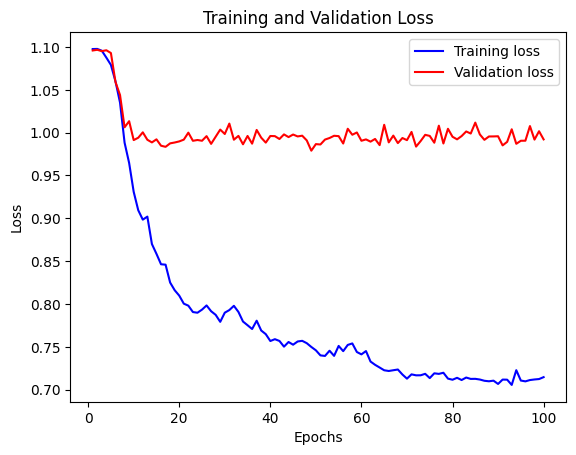

In [37]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

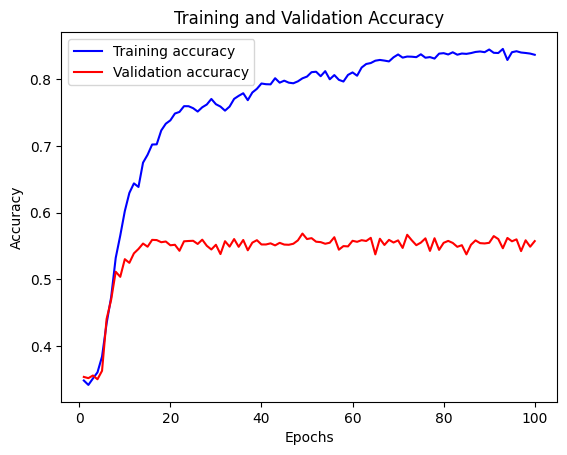

In [38]:
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
model_name_v2 = '/kaggle/working/trained_model_v2.pth'
torch.save(net.state_dict(), model_name_v2)

In [40]:
model = SentimentRNN(n_vocab, n_output, n_embed, n_hidden, n_layers)
model.load_state_dict(torch.load(model_name))
model.to(device)

SentimentRNN(
  (embedding): Embedding(55630, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [41]:
test_losses = []
num_correct = 0

h = net.init_hidden(batch_size)

net.eval()

for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    
    output, h = net(inputs, h)
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    pred = torch.argmax(output, dim=1)
    correct_tensor = pred.eq(labels)
    num_correct += torch.sum(correct_tensor).item()

print("Test loss: {:.6f}".format(np.mean(test_losses)))

test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.6f}".format(test_acc))

Test loss: 1.063713
Test accuracy: 0.475196


In [42]:
def predict(model, sentence):
    words = clean_text(sentence)
    text_ints = phrase_to_ints(words)
    padded_text = pad_sequences(text_ints, seq_length)
    
    text_tensor = torch.from_numpy(padded_text)
    text_tensor = text_tensor.to(device)
    
    model.eval()
    
    batch_size = text_tensor.size(0)
    h = model.init_hidden(batch_size)
    
    output, _ = model(text_tensor, h)
    predicted = output.flatten().cpu().detach().numpy()
    label = np.argmax(predicted)
    
    return predicted, label

In [43]:
sentence = "I love this movie. The scence is stunning and the action is quite good. I really enjoyed it!"
labels = ['Negative', 'Neutral', 'Positive']

predicted, label = predict(net, sentence)
print(predicted)
print(labels[label])

predicted, label = predict(model, sentence)
print(predicted)
print(labels[label])

100%|██████████| 1/1 [00:00<00:00, 9576.04it/s]


[3.3344222e-08 2.2194880e-07 9.9999976e-01]
Positive


100%|██████████| 1/1 [00:00<00:00, 8886.24it/s]

[2.7473852e-06 1.9502217e-03 9.9804699e-01]
Positive
